In [81]:
# import
import statsmodels.api as sm
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

In [ ]:
version_v3_03091200

# Building a regression model.

## Loading Data

In [3]:
# create connection
conn = sqlite3.connect('../data/mtl_bike_rentals.sqlite')

### Considerations for outliers
As suggested during our EDA, we should remove some outliers while querying our database.
- Total_bikes between 10 and 35
- Rating above 6

We could also try to do 2 seperate model with review counts as two categories:
- Underated, review_counts < 100
- Well rated, review_counts >= 100

Addition: We didn't evaluate that in the EDA, but with the database it is now easy to pull new characteristics.<br>
We will add the number of POI's

#### First model:
- From Yelp
- Full review counts
- Outliers removed

In [22]:
# Select data for first model

yelp_model_all_review = pd.read_sql(
    """
    SELECT
        s.station_name AS name,
        s.station_id AS station,
        AVG(s.total_bikes) AS total_bikes,
        AVG(pd.to_station_m) AS avg_distance_to_station_m,
        AVG(review_count) AS avg_review,
        AVG(p.rating) AS avg_rating,
        AVG(p.price) AS avg_price,
        COUNT(*) AS number_poi
    FROM
        stations s
    JOIN poi_detail pd USING(station_id)
    JOIN pois p USING(poi_id)
    JOIN api a USING(poi_id)
    WHERE
        api_name = 'Yelp'
        AND total_bikes BETWEEN 10 AND 35
        AND rating > 6
    GROUP BY 1, 2
    HAVING
        avg_review NOT NULL
    ORDER BY
        station;
    """, conn
)

print(yelp_model_all_review)

                                              name  station  total_bikes  \
0                            Union / Ste-Catherine       26         35.0   
1                            University / des Pins       27         35.0   
2                                 Dorion / Ontario       28         35.0   
3                   de la Montagne / Ste-Catherine       29         35.0   
4                          Larivière / de Lorimier       30         35.0   
..                                             ...      ...          ...   
759                       de Chateaubriand / Jarry      789         11.0   
760                           Cégep Marie-Victorin      790         11.0   
761                         Ste-Famille / des Pins      791         10.0   
762                            Waverly / Van Horne      792         10.0   
763  Gare d'autocars de Montréal (Berri / Ontario)      793         10.0   

     avg_distance_to_station_m  avg_review  avg_rating  avg_price  number_poi  
0      

In [23]:
# View info (in case of datatype error)
yelp_model_all_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       764 non-null    object 
 1   station                    764 non-null    int64  
 2   total_bikes                764 non-null    float64
 3   avg_distance_to_station_m  764 non-null    float64
 4   avg_review                 764 non-null    float64
 5   avg_rating                 764 non-null    float64
 6   avg_price                  764 non-null    float64
 7   number_poi                 764 non-null    int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 47.9+ KB


In [29]:
yelp_model_all_review.describe()

,station,total_bikes,avg_distance_to_station_m,avg_review,avg_rating,avg_price,number_poi
count,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000
mean,409.183246,20.153141,540.103511,112.643911,8.323556,2.084117,14.972513
std,221.846358,5.268304,163.064019,134.985159,0.344017,0.233127,4.696618
min,26.000000,10.000000,104.500000,1.000000,7.187500,1.500000,1.000000
25%,217.750000,16.000000,417.519444,12.500000,8.125000,1.916667,12.000000
50%,409.500000,19.000000,537.961300,45.975000,8.342105,2.054094,16.000000
75%,601.250000,23.000000,665.508824,176.447368,8.519737,2.216270,19.000000
max,793.000000,35.000000,985.200000,620.631579,10.000000,3.000000,20.000000


As per the result of our EDA:
- Dependant variable is total_bikes
- Independant variables are number_poi, rating, distance, prices (thougth strongly correlated with the others) and review count (potential category)

We will conduct 

In [25]:
# Run model with all variables
y = yelp_model_all_review['total_bikes']
X = yelp_model_all_review.drop(['total_bikes', 'name', 'station'], axis=1)
X = sm.add_constant(X)
X

,const,avg_distance_to_station_m,avg_review,avg_rating,avg_price,number_poi
0,1.0,401.842105,265.947368,8.105263,2.421053,19
1,1.0,771.000000,530.777778,8.500000,2.444444,9
2,1.0,539.062500,113.312500,8.242188,2.250000,16
3,1.0,254.650000,292.850000,8.031250,2.350000,20
4,1.0,618.187500,68.125000,7.960938,1.875000,16
...,...,...,...,...,...,...
759,1.0,352.125000,31.812500,8.171875,1.750000,16
760,1.0,764.428571,4.285714,8.232143,2.000000,7
761,1.0,623.000000,427.833333,8.375000,2.222222,18
762,1.0,534.705882,155.705882,8.411765,2.294118,17


In [26]:
# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     18.27
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           3.75e-17
Time:                        22:52:18   Log-Likelihood:                -2309.6
No. Observations:                 764   AIC:                             4631.
Df Residuals:                     758   BIC:                             4659.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

All p-value are below .005 except Distance. But Adjusted R square is nearly zero...

In [27]:
# Remove highest p_value (distance), repeat
y = yelp_model_all_review['total_bikes']
X = yelp_model_all_review.drop(['total_bikes', 'name', 'station', 'avg_distance_to_station_m'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     22.30
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           1.98e-17
Time:                        22:52:46   Log-Likelihood:                -2310.7
No. Observations:                 764   AIC:                             4631.
Df Residuals:                     759   BIC:                             4655.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.2190      4.981      5.063      0.0

Since price is correlated to rating, lets remove it too.

In [30]:
# Remove highest p_value (distance), repeat
y = yelp_model_all_review['total_bikes']
X = yelp_model_all_review.drop(['total_bikes', 'name', 'station', 'avg_distance_to_station_m', 'avg_rating'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     26.30
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           3.40e-16
Time:                        23:00:04   Log-Likelihood:                -2315.4
No. Observations:                 764   AIC:                             4639.
Df Residuals:                     760   BIC:                             4657.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1366      1.953      5.703      0.0

In [31]:
# Remove highest p_value (distance), repeat
y = yelp_model_all_review['total_bikes']
X = yelp_model_all_review.drop(['total_bikes', 'name', 'station', 'avg_distance_to_station_m', 'avg_rating', 'avg_price'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     33.61
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           1.03e-14
Time:                        23:00:37   Log-Likelihood:                -2320.8
No. Observations:                 764   AIC:                             4648.
Df Residuals:                     761   BIC:                             4661.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.2272      0.624     27.609      0.0

### OVERVIEW
None of these variables show any potential at all. The only one close was the first one with all variables. All p-value were below .005 except distance and number of poi.

#### Second model:
- From Yelp
- Underrated review
- Outliers removed

In [36]:
# Select data

yelp_model_low_review = pd.read_sql(
    """
    SELECT
        s.station_name AS name,
        s.station_id AS station,
        AVG(s.total_bikes) AS total_bikes,
        AVG(pd.to_station_m) AS avg_distance_to_station_m,
        AVG(review_count) AS avg_review,
        AVG(p.rating) AS avg_rating,
        AVG(p.price) AS avg_price,
        COUNT(*) AS number_poi
    FROM
        stations s
    JOIN poi_detail pd USING(station_id)
    JOIN pois p USING(poi_id)
    JOIN api a USING(poi_id)
    WHERE
        api_name = 'Yelp'
        AND total_bikes BETWEEN 10 AND 35
        AND rating > 6
        AND review_count < 100
    GROUP BY 1, 2
    HAVING
        avg_review NOT NULL
    ORDER BY
        station;
    """, conn
)

print(yelp_model_low_review)

                                              name  station  total_bikes  \
0                            Union / Ste-Catherine       26         35.0   
1                            University / des Pins       27         35.0   
2                                 Dorion / Ontario       28         35.0   
3                   de la Montagne / Ste-Catherine       29         35.0   
4                          Larivière / de Lorimier       30         35.0   
..                                             ...      ...          ...   
757                       de Chateaubriand / Jarry      789         11.0   
758                           Cégep Marie-Victorin      790         11.0   
759                         Ste-Famille / des Pins      791         10.0   
760                            Waverly / Van Horne      792         10.0   
761  Gare d'autocars de Montréal (Berri / Ontario)      793         10.0   

     avg_distance_to_station_m  avg_review  avg_rating  avg_price  number_poi  
0      

In [37]:
# Remove highest p_value (distance), repeat
y = yelp_model_low_review['total_bikes']
X = yelp_model_low_review.drop(['total_bikes', 'name', 'station'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     19.27
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           4.39e-18
Time:                        23:07:18   Log-Likelihood:                -2300.0
No. Observations:                 762   AIC:                             4612.
Df Residuals:                     756   BIC:                             4640.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Slightly better, lets remove prices (we know its correlated to the other)

In [38]:
# Remove highest p_value (distance), repeat
y = yelp_model_low_review['total_bikes']
X = yelp_model_low_review.drop(['total_bikes', 'name', 'station', 'avg_price'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     24.09
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           8.81e-19
Time:                        23:08:26   Log-Likelihood:                -2300.1
No. Observations:                 762   AIC:                             4610.
Df Residuals:                     757   BIC:                             4633.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Improving a bit, lets remove number of poi

In [40]:
# Remove highest p_value (distance), repeat
y = yelp_model_low_review['total_bikes']
X = yelp_model_low_review.drop(['total_bikes', 'name', 'station', 'avg_price', 'number_poi'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     31.36
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           4.07e-19
Time:                        23:09:32   Log-Likelihood:                -2301.2
No. Observations:                 762   AIC:                             4610.
Df Residuals:                     758   BIC:                             4629.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

I think its the best we can get, and it make sense.  Lets double check by keeping only review this time

In [50]:
# Remove highest p_value (distance), repeat
y = yelp_model_low_review['total_bikes']
X = yelp_model_low_review['avg_review']
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     80.30
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           2.46e-18
Time:                        23:14:23   Log-Likelihood:                -2307.5
No. Observations:                 762   AIC:                             4619.
Df Residuals:                     760   BIC:                             4628.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.6607      0.331     53.360      0.0

In [ ]:
It looks like only the review itself can explian  (by only 10% chance).

#### Third model:
- From Yelp
- Well rated review
- Outliers removed

In [51]:
# Select data
yelp_model_high_review = pd.read_sql(
    """
    SELECT
        s.station_name AS name,
        s.station_id AS station,
        AVG(s.total_bikes) AS total_bikes,
        AVG(pd.to_station_m) AS avg_distance_to_station_m,
        AVG(review_count) AS avg_review,
        AVG(p.rating) AS avg_rating,
        AVG(p.price) AS avg_price,
        COUNT(*) AS number_poi
    FROM
        stations s
    JOIN poi_detail pd USING(station_id)
    JOIN pois p USING(poi_id)
    JOIN api a USING(poi_id)
    WHERE
        api_name = 'Yelp'
        AND total_bikes BETWEEN 10 AND 35
        AND rating > 6
        AND review_count >= 100
    GROUP BY 1, 2
    HAVING
        avg_review NOT NULL
    ORDER BY
        station;
    """, conn
)

print(yelp_model_high_review)

                                              name  station  total_bikes  \
0                            Union / Ste-Catherine       26         35.0   
1                            University / des Pins       27         35.0   
2                                 Dorion / Ontario       28         35.0   
3                   de la Montagne / Ste-Catherine       29         35.0   
4                          Larivière / de Lorimier       30         35.0   
..                                             ...      ...          ...   
440                          Laval / du Mont-Royal      786         11.0   
441                         Paré / Mountain Sights      787         11.0   
442                         Ste-Famille / des Pins      791         10.0   
443                            Waverly / Van Horne      792         10.0   
444  Gare d'autocars de Montréal (Berri / Ontario)      793         10.0   

     avg_distance_to_station_m  avg_review  avg_rating  avg_price  number_poi  
0      

In [56]:
# Remove highest p_value (distance), repeat
y = yelp_model_high_review['total_bikes']
X = yelp_model_high_review.drop(['total_bikes', 'name', 'station'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     6.322
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           1.11e-05
Time:                        23:18:48   Log-Likelihood:                -1372.1
No. Observations:                 445   AIC:                             2756.
Df Residuals:                     439   BIC:                             2781.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Not a good start

In [59]:
# Remove highest p_value (distance), repeat
y = yelp_model_high_review['total_bikes']
X = yelp_model_high_review.drop(['total_bikes', 'name', 'station', 'avg_distance_to_station_m'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.920
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           3.59e-06
Time:                        23:20:06   Log-Likelihood:                -1372.1
No. Observations:                 445   AIC:                             2754.
Df Residuals:                     440   BIC:                             2775.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.0707      6.283      5.104      0.0

Not going anywhere. Not a good model.

#### Fourth model:
- From combined data
- Outliers removed

In [61]:
# Select data
# Select data
comb_model = pd.read_sql(
    """
    SELECT
        s.station_name AS name,
        s.station_id AS station,
        AVG(s.total_bikes) AS total_bikes,
        AVG(pd.to_station_m) AS avg_distance_to_station_m,
        AVG(review_count) AS avg_review,
        AVG(p.rating) AS avg_rating,
        AVG(popularity) AS avg_popularity,
        AVG(p.price) AS avg_price,
        COUNT(*) AS number_poi
    FROM
        stations s
    JOIN poi_detail pd USING(station_id)
    JOIN pois p USING(poi_id)
    JOIN api a USING(poi_id)
    WHERE
        total_bikes BETWEEN 10 AND 35
        AND rating > 6
    GROUP BY 1, 2
    HAVING
        avg_review NOT NULL
    ORDER BY
        station;
    """, conn
)

print(comb_model)

                                              name  station  total_bikes  \
0                            Union / Ste-Catherine       26         35.0   
1                            University / des Pins       27         35.0   
2                                 Dorion / Ontario       28         35.0   
3                   de la Montagne / Ste-Catherine       29         35.0   
4                          Larivière / de Lorimier       30         35.0   
..                                             ...      ...          ...   
759                       de Chateaubriand / Jarry      789         11.0   
760                           Cégep Marie-Victorin      790         11.0   
761                         Ste-Famille / des Pins      791         10.0   
762                            Waverly / Van Horne      792         10.0   
763  Gare d'autocars de Montréal (Berri / Ontario)      793         10.0   

     avg_distance_to_station_m  avg_review  avg_rating  avg_popularity  \
0            

In [62]:
comb_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       764 non-null    object 
 1   station                    764 non-null    int64  
 2   total_bikes                764 non-null    float64
 3   avg_distance_to_station_m  764 non-null    float64
 4   avg_review                 764 non-null    float64
 5   avg_rating                 764 non-null    float64
 6   avg_popularity             764 non-null    float64
 7   avg_price                  764 non-null    float64
 8   number_poi                 764 non-null    int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 53.8+ KB


In [63]:
comb_model.describe()

,station,total_bikes,avg_distance_to_station_m,avg_review,avg_rating,avg_popularity,avg_price,number_poi
count,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000
mean,409.183246,20.153141,607.003128,112.643911,8.093779,0.873875,1.556775,57.392670
std,221.846358,5.268304,104.867911,134.985159,0.199224,0.067522,0.205750,14.144462
min,26.000000,10.000000,251.952381,1.000000,7.545621,0.681966,1.071429,4.000000
25%,217.750000,16.000000,540.570076,12.500000,7.950780,0.822628,1.393443,53.000000
50%,409.500000,19.000000,611.689027,45.975000,8.086261,0.861444,1.543219,63.000000
75%,601.250000,23.000000,681.798676,176.447368,8.216993,0.939071,1.724638,67.000000
max,793.000000,35.000000,919.590909,620.631579,8.622464,0.978680,2.088235,70.000000


In [64]:
# Run model
y = comb_model['total_bikes']
X = comb_model.drop(['total_bikes', 'name', 'station'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     15.19
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           1.77e-16
Time:                        23:24:47   Log-Likelihood:                -2309.7
No. Observations:                 764   AIC:                             4633.
Df Residuals:                     757   BIC:                             4666.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Decively, the number of poi in the area doesn' t seems to have a great impact.

In [65]:
# Run model
y = comb_model['total_bikes']
X = comb_model.drop(['total_bikes', 'name', 'station', 'number_poi'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     18.08
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           5.71e-17
Time:                        23:26:21   Log-Likelihood:                -2310.1
No. Observations:                 764   AIC:                             4632.
Df Residuals:                     758   BIC:                             4660.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [67]:
# Run model
y = comb_model['total_bikes']
X = comb_model.drop(['total_bikes', 'name', 'station', 'number_poi', 'avg_distance_to_station_m'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     21.86
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           4.31e-17
Time:                        23:27:16   Log-Likelihood:                -2311.5
No. Observations:                 764   AIC:                             4633.
Df Residuals:                     759   BIC:                             4656.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             25.0953      9.083      2.

In [68]:
# Run model
y = comb_model['total_bikes']
X = comb_model.drop(['total_bikes', 'name', 'station', 'number_poi', 'avg_distance_to_station_m', 'avg_review'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     27.89
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           4.09e-17
Time:                        23:28:04   Log-Likelihood:                -2313.2
No. Observations:                 764   AIC:                             4634.
Df Residuals:                     760   BIC:                             4653.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.4508      7.831      2.

In [69]:
# Run model
y = comb_model['total_bikes']
X = comb_model.drop(['total_bikes', 'name', 'station', 'number_poi', 'avg_distance_to_station_m', 'avg_review', 'avg_rating'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     39.93
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           3.23e-17
Time:                        23:28:45   Log-Likelihood:                -2315.0
No. Observations:                 764   AIC:                             4636.
Df Residuals:                     761   BIC:                             4650.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.4285      2.395      1.

It's the first time we get a model with al p_value below 0.005. But we know that price and popularity are strongly related, so this model is not valid either.

Let's try with our guts!

In [72]:
# Run model
y = comb_model['total_bikes']
X = comb_model.drop(['total_bikes', 'name', 'station', 'avg_price', 'avg_distance_to_station_m'], axis=1)
X = sm.add_constant(X)

# Run model and output summary
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     20.64
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           3.70e-16
Time:                        23:31:17   Log-Likelihood:                -2313.7
No. Observations:                 764   AIC:                             4637.
Df Residuals:                     759   BIC:                             4661.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             25.4357      9.126      2.

That could be our best guess since none of the model is good enough.

### Residual Plots
for testing our model against the linear regression assumptions
#### Normality

In [73]:
residuals = results.resid
residuals

0      12.433231
1      10.818298
2      13.773108
3      12.110457
4      15.705094
         ...    
759    -8.416502
760    -7.714844
761   -13.147623
762   -11.174384
763   -12.388272
Length: 764, dtype: float64

<Axes: ylabel='Count'>

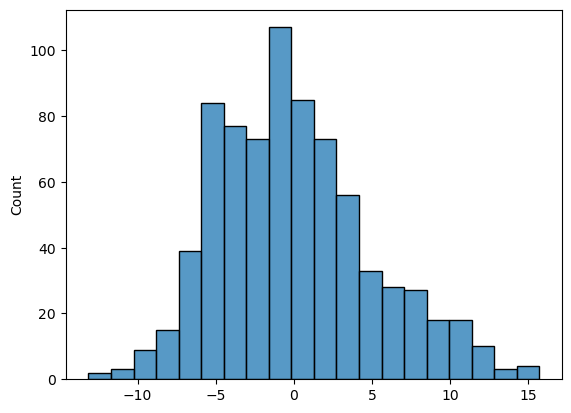

In [76]:
sns.histplot(residuals)

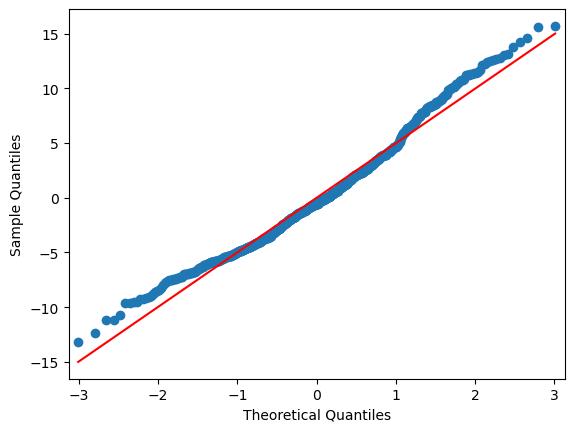

In [79]:
sm.qqplot(residuals, line="r")

In [82]:
scipy.stats.shapiro(residuals)

ShapiroResult(statistic=0.9788070321083069, pvalue=4.476150117227462e-09)

We cannot reject null hypothesis, the data is not drawn from a normal distribution.

#### Homoscedasticity

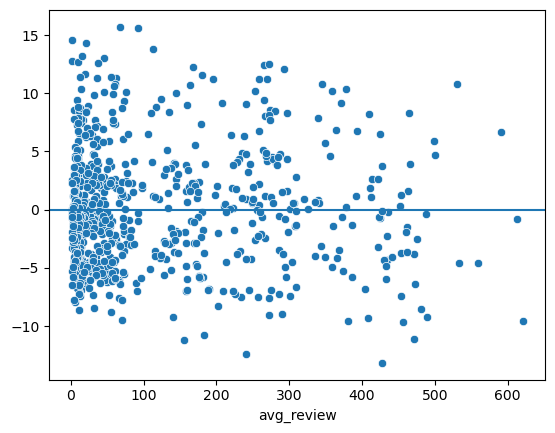

In [83]:
ax = sns.scatterplot(x=comb_model['avg_review'], y=residuals)
ax.axhline(0) #horizontal line at 0

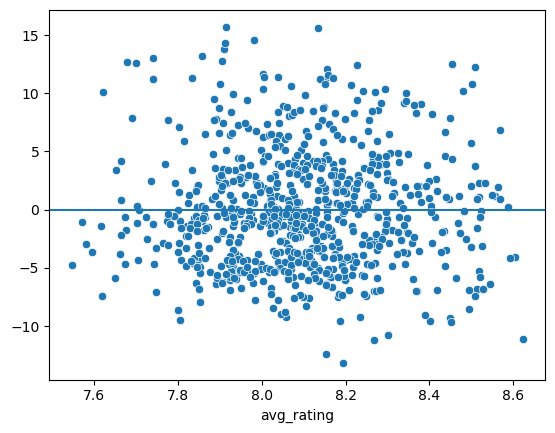

In [85]:
ax = sns.scatterplot(x=comb_model['avg_rating'], y=residuals)
ax.axhline(0) #horizontal line at 0

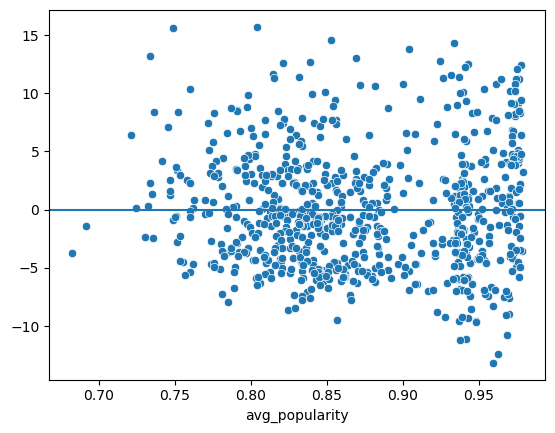

In [86]:
ax = sns.scatterplot(x=comb_model['avg_popularity'], y=residuals)
ax.axhline(0) #horizontal line at 0

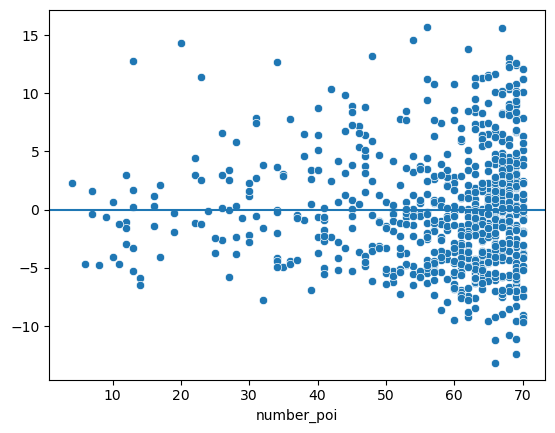

In [87]:
ax = sns.scatterplot(x=comb_model['number_poi'], y=residuals)
ax.axhline(0) #horizontal line at 0

In [88]:
stat, p, f_stat, f_p = sm.stats.diagnostic.het_breuschpagan(residuals,results.model.exog)
print(p,f_p)

0.0011543348134296985 0.0010922071105660652


We do not have homoscedasticity either.

## CONCLUSION

With the data we have collected, we do not have enougth strong relationship between any independant variables and the dependant variable.
It would be hard to try to predict the number of bikes per station based on the POIs characteristics.<br>

As far as I am concerned, Montréal is a small city compare to New York for example. New York as almost 2000 stations and Montréal as 800. Thats a lot of stations for a small area. So, I guess, even if we know how much bike we need with a model, the space is limited, so it affect distance and quantity of bike availabe. Thought the ratings of POIs should be important, we mostly only covers the 'restaurant' category. But, when you rent a bike, its to see the environment outside, the achitecture, the people.<br>

If we really need to predict the quanity of bike, we would need to consider all these other aspect.

# Stretch

## How can you turn the regression model into a classification model?

I think it could be interresting to re-evaluate the model using the perception of the customers about the bike rentals company.

1) I would conduct a survey to know if " There is ENOUGH bikes at the station".
2) I could then classify the total bikes in 2 category (or more):
    - 0: Not enough bikes
    - 1: Enough bikes
3) I would then try to model using the POI attributes to see the relationship between the data and the customer affirmation.

The model could then be used to predict the number of bikes NEEDED at a station (do we have enough or not), or for a new station to be build (how many to start with).